Tyle wierszy ma null:  0


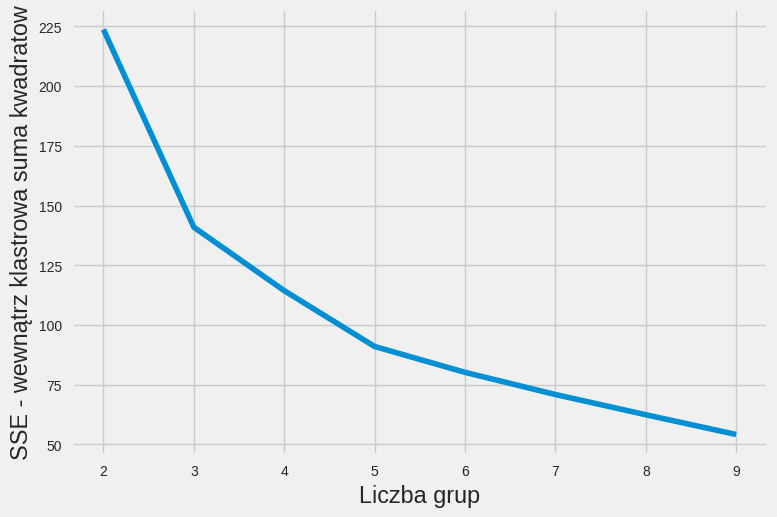

[0.580184463257396, 0.4589717867018717, 0.3868603029959941, 0.344785734559291, 0.32890489831374464, 0.32703225233732597, 0.33267060886097, 0.35007755038560684]


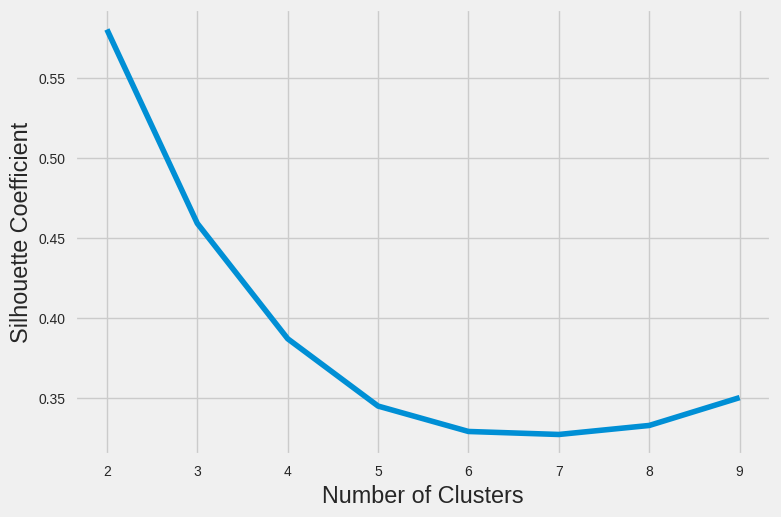

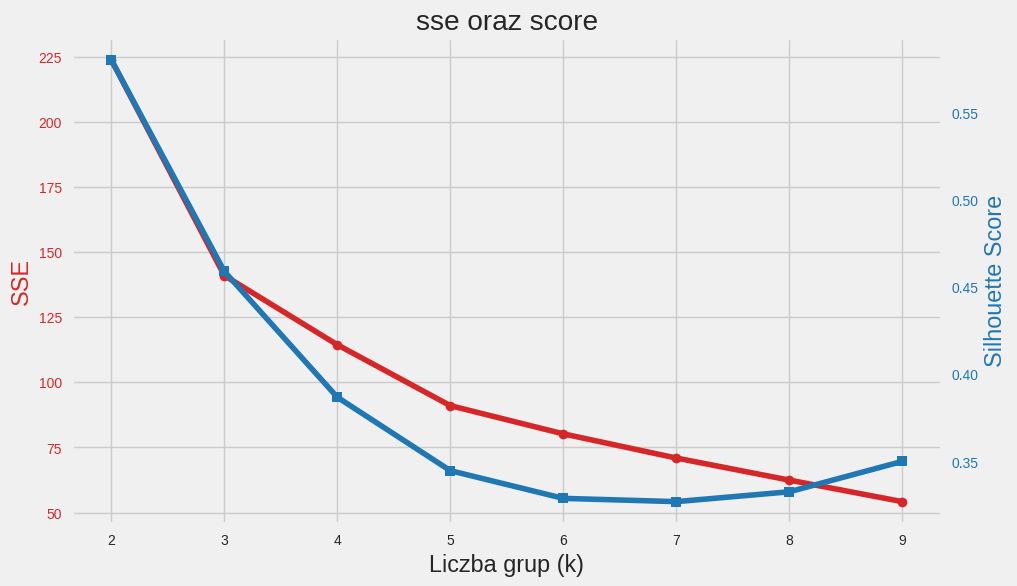

Najlepsze k: 2 (Score: 0.580)

--- Analiza DBSCAN ---
a) Wyznaczona minPts (2 * 4 wymiary): 8
b) Automatycznie wyznaczony Epsilon (punkt kolana): 0.9506


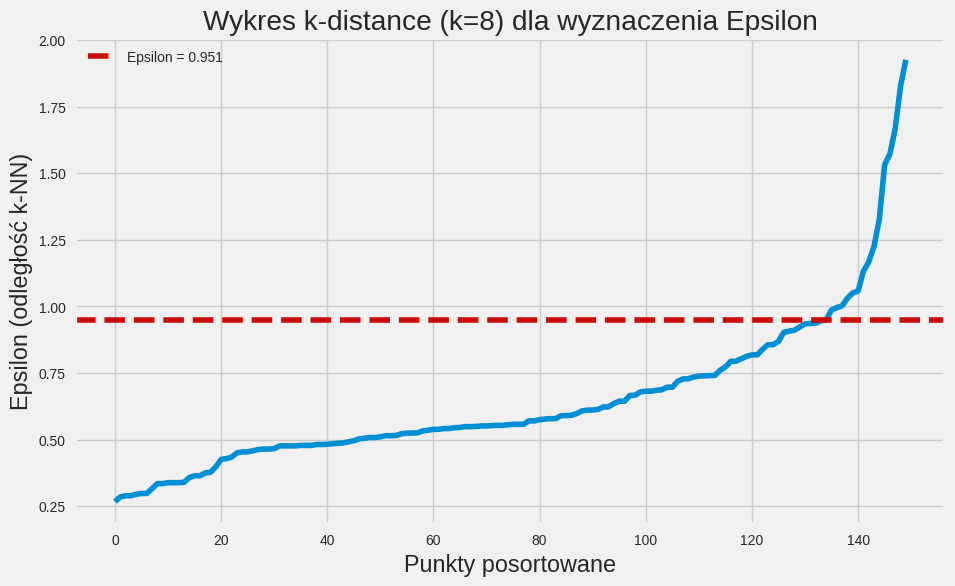

c) Wyniki DBSCAN:
   Liczba znalezionych grup: 2
   Liczba punktów szumu (outliers): 4
   Silhouette Score dla DBSCAN: 0.547

--- PORÓWNANIE WYNIKÓW ---
DBSCAN = KMeans.
KMeans lepszy


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

from kneed import KneeLocator # zaimportowano dla potrzeb oreślenia punktu łokcia

from yellowbrick.cluster import SilhouetteVisualizer


# SPRAWDZ SCIEZKE
df = pd.read_csv('dane_iris.csv', header=0)


# Sprawdzenie czy sa jakieś null lub NaN
print('Tyle wierszy ma null: ', df.isnull().sum().sum())

# standaryzacja danych
scaler = StandardScaler()
std_df = scaler.fit_transform(df)

#teraz mamy przygotowane dane

# A tu uruchomimy kmeans 9 razy (dla k od 2 do 10), zapiszemy wewnątrzklastrowe sumy kwadratów (sse) dla każdego z klastra
# i potem przedstawimy te wartości na wykresie
# dodatkowo pliczymy wartośc wspłczynnika profilu (tu możesz też poczytać o tym wskaźniku:
#                           https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam )
# obie wielkości wyświetlimy na niezależnych wykresach

sse = []
silhouette_coefficients = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init='random', n_init=100, max_iter=100, tol=1e-04, random_state=0)
    kmeans.fit(std_df, sample_weight=None)
    sse.append(kmeans.inertia_)
    score = silhouette_score(std_df, kmeans.labels_)
    silhouette_coefficients.append(score)


#wykres SEE
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), sse)
plt.xticks(range(2, 10))
plt.xlabel("Liczba grup")
plt.ylabel("SSE - wewnątrz klastrowa suma kwadratow")
plt.grid
plt.show()

#wykres silhouette
print(silhouette_coefficients)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

# Polecenie nr 1:
# Czy potafiłbyś umieścić sse oraz score na jednym wykresie, prezentując jedną wielkość na osi pomocniczej?
# jeśli tak to zmodyfikuje skrytp, opisz też co zrobiłeś

sse = []
silhouette_coefficients = []
k_range = range(2, 10)

# Pętla KMeans
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='random', n_init=100, max_iter=100, tol=1e-04, random_state=0)
    kmeans.fit(std_df)
    sse.append(kmeans.inertia_)
    score = silhouette_score(std_df, kmeans.labels_)
    silhouette_coefficients.append(score)

# Tworzenie wykresu z dwiema osiami
fig, ax1 = plt.subplots(figsize=(10, 6))

plt.style.use("fivethirtyeight")
color = 'tab:red'
ax1.set_xlabel('Liczba grup (k)')
ax1.set_ylabel('SSE', color=color)
ax1.plot(k_range, sse, color=color, marker='o', label='SSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Tworzenie drugiej osi
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_range, silhouette_coefficients, color=color, marker='s', label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False) # Wyłączamy siatkę dla drugiej osi, żeby nie zaciemniać obrazu

plt.title('sse oraz score')
plt.show()

# Znalezienie najlepszego k
best_k_idx = np.argmax(silhouette_coefficients)
best_k_kmeans = k_range[best_k_idx]
best_score_kmeans = silhouette_coefficients[best_k_idx]
print(f"Najlepsze k: {best_k_kmeans} (Score: {best_score_kmeans:.3f})")

# Polecenie 2
# Zastosujemy teraz algorytm DBSCAN. Opis tego algorytmu znajdziesz m.in. pod adresem
# https://www.reneshbedre.com/blog/dbscan-python.html
# a) wyznacz parametr minPts dla DBSCAN
# b) przygotuj skrypt do automatycznego wyznaczenia parametru Epsilon w algorytmie DBSCAN, wykreśl też wykres
# pozwalający odczytać tę wartość, opisz działanie skrytpu
# c) dokonaj grupowanie wczytanych danych używając algorytmu DBSCAN, wyświetl informację o liczbie grup wskazanych z użyciem
# tego algorytmu, wyznacz dla uzyskanego pogrupowania danych wartość współczynnika profilu. Czy wynik różni sie od wyniku otrzymanego
# z wykorzsystaniem k-means (niech odpowiedź będzie się generowała automatycznie, tj. stosując warunek

print("\n--- Analiza DBSCAN ---")

# a) Wyznaczenie minPts
dim = std_df.shape[1]
min_pts = 2 * dim
print(f"a) Wyznaczona minPts (2 * {dim} wymiary): {min_pts}")

# b) Automatyczne wyznaczenie Epsilon
# Obliczamy sąsiadów
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(std_df)
distances, indices = neighbors_fit.kneighbors(std_df)

# Sortujemy odległości do k-tego sąsiada 
distances = np.sort(distances[:, min_pts-1], axis=0)

# Używamy KneeLocator do znalezienia punktu przegięcia
kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
optimal_eps = distances[kneedle.knee]

print(f"b) Automatycznie wyznaczony Epsilon (punkt kolana): {optimal_eps:.4f}")

# Wykres k-distance graph z zaznaczonym punktem
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Epsilon = {optimal_eps:.3f}')
plt.title(f'Wykres k-distance (k={min_pts}) dla wyznaczenia Epsilon')
plt.xlabel('Punkty posortowane')
plt.ylabel('Epsilon (odległość k-NN)')
plt.legend()
plt.show()

# c) Uruchomienie DBSCAN i porównanie
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_pts)
dbscan_labels = dbscan.fit_predict(std_df)

# Liczba klastrów
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"c) Wyniki DBSCAN:")
print(f"   Liczba znalezionych grup: {n_clusters_dbscan}")
print(f"   Liczba punktów szumu (outliers): {n_noise}")

# Obliczenie Silhouette dla DBSCAN
if n_clusters_dbscan > 1:
    dbscan_score = silhouette_score(std_df, dbscan_labels)
    print(f"   Silhouette Score dla DBSCAN: {dbscan_score:.3f}")
else:
    dbscan_score = -1
    print("   Nie można policzyć Silhouette Score (za mało klastrów lub same szumy).")

# Generowanie odpowiedzi
print("\n--- PORÓWNANIE WYNIKÓW ---")
if n_clusters_dbscan == best_k_kmeans:
    porownanie_grup = "DBSCAN = KMeans."
else:
    porownanie_grup = f"Wyniki różnią się liczbą grup (KMeans optymalne: {best_k_kmeans}, DBSCAN: {n_clusters_dbscan})."

if dbscan_score > best_score_kmeans:
    porownanie_jakosci = "DBSCAN lepszy."
else:
    porownanie_jakosci = "KMeans lepszy"

print(f"{porownanie_grup}")
print(f"{porownanie_jakosci}")